In [1]:
%matplotlib inline
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import matplotlib as mpl

mpl.rcParams['font.size'] = 20

import numpy as np
import pandas as pd
from activ import TrackTBIFile
from activ.viz import get_nmf_colors, get_nmf_labels, get_embeddings, get_nmf_feature_types
from activ.nmf.viz import weights_pie_scatter
from activ.cca.viz import cross_decomp_scatter
import matplotlib.colors as mpc
from activ.paper import plot_cat2cont

/Users/ajtritt/anaconda3/envs/activ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Conceptual figure for CCA
2. Cumulative outcome variance explained as a function of sorted CVs
3. Scatter plots for first CV
4. scatter plot for second CV
5. Horizontal barplots. Mirror current orientations across vertical axis
6. Heatmap


In [2]:
CONCEPTUAL_PATH = "../../paper/cross-decomposition-paper-good.png"
ALL_CVS_PATH = "final_ccas/tracktbi.cca.all_cvs.sparse.h5"
NMFS_PATH = "../NMF/tracktbi.reg_nmf.h5"

# Conceptual Figure

In [3]:
def add_border(img, size=10):
    sh = img.shape
    new_sh = (sh[0] + 2*size, sh[1] + 2*size, sh[2])
    ret = np.ones(new_sh)
    ret[size:-size, size:-size, :] = img
    return ret

def display_img(path, ax=None, border=10):
    if ax == None:
        ax = plt.gca()
    img = plt.imread(path)
    if not (border == None or border == 0):
        img = add_border(img, size=border)
    ax.imshow(img)
    ax.axis('off')

# Cumulative Explained Variance

In [4]:
from activ.cca.utils import compute_explained_variance

def get_exp_var(path):
    tbifile = TrackTBIFile(path)
    cv_bm = tbifile.cca.bm
    cv_oc = tbifile.cca.oc
    exp_var, n_comp = compute_explained_variance(cv_bm, cv_oc, tbifile.outcomes, perc_var=1.0, method='cos')
    return exp_var

def plot_exp_var(exp_var, ylabel=None, ax=None, fontsize=24, color='black', n_cvs=None):
    if ax is None:
        ax = plt.gca()
    if isinstance(exp_var, str):
        exp_var = get_exp_var(path)
    exp_var = np.sort(exp_var)[::-1]
    ax.plot(exp_var, color=color)
    ax.set_xlabel('Canonical variate', fontsize=fontsize)
    #ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params('both', labelsize=fontsize)
    if n_cvs is not None:
        ax.axvline(n_cvs, color='red', ls='--')
    
def plot_cum_exp_var(exp_var, ylabel=None, ax=None, fontsize=24, color='black', n_cvs=None):
    if ax is None:
        ax = plt.gca()
    if isinstance(exp_var, str):
        exp_var = get_exp_var(path)
    cum = np.sort(exp_var)[::-1].cumsum()
    ax.plot(cum, color=color)
    ax.set_xlabel('Canonical variate', fontsize=fontsize)
    #ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params('both', labelsize=fontsize)
    #ax.axhline(0.95, ls=':', color='k')
    ytick = [0.0, 0.9]
    ax.set_yticks(ytick)
    ax.set_yticklabels(ytick)
    if n_cvs is not None:
        ax.axvline(n_cvs, color='red', ls='--')


In [5]:
N_CVS = 9
exp_var = get_exp_var(ALL_CVS_PATH)
sig_cvs = np.argsort(exp_var)[::-1][:N_CVS]
print(sig_cvs)

[ 1  0  6 14 13 45 24  2  3]


## Write a master file with all the results

In [6]:
tbifile = TrackTBIFile(ALL_CVS_PATH)
_tbifile = TrackTBIFile(NMFS_PATH)

bm_weights = _tbifile.nmf.bm
oc_weights = _tbifile.nmf.oc
bm_bases = _tbifile.nmf.bm_bases
oc_bases = _tbifile.nmf.oc_bases
with h5py.File('all_results.tbifile.h5', 'w') as f:
    TrackTBIFile.write(f, tbifile.biomarkers, tbifile.outcomes, tbifile.biomarker_features, tbifile.outcome_features, tbifile.patient_ids)
    TrackTBIFile.write_nmf(f, bm_weights, oc_weights, bm_bases, oc_bases)
    TrackTBIFile.write_cca(f, tbifile.cca.bm[:, sig_cvs], tbifile.cca.oc[:, sig_cvs], tbifile.cca.bm_bases[:, sig_cvs], tbifile.cca.oc_bases[:, sig_cvs])
    TrackTBIFile.write_viz(f, bm_emb=_tbifile.biomarker_emb, oc_emb=_tbifile.outcome_emb, 
                           bm_colors=_tbifile.biomarker_colors, oc_colors=_tbifile.outcome_colors,
                           bm_labels=_tbifile.biomarker_labels, oc_labels=_tbifile.outcome_labels)
    TrackTBIFile.write_feat_types(f, {'nmf': _tbifile.biomarker_type['nmf'].values}, {'nmf': _tbifile.outcome_type['nmf'].values})

# Barplots

In [7]:
from activ.viz import get_nmf_colors, get_nmf_labels, get_embeddings, get_nmf_feature_types


def drop_small(weights, thresh=0.1):
    mat = np.cumsum(np.sort(np.abs(weights), axis=0)[::-1], axis=0)
    mat = mat/mat[-1,:] 
    mat = mat.T
    ret = weights.T.copy()
    for i in range(mat.shape[0]):
        cw = mat[i]
        idx = np.where(cw >= thresh)[0][0]
        cutoff = cw[idx] - cw[idx-1]
        ret[i][np.abs(ret[i]) <= cutoff] = 0.0
    return ret.T


def get_barplot_data(cv_path, nmf_path, n_cvs=None, nz_loadings=True, thresh=None):
    
    rownorm = lambda X: (X.T / X.sum(axis=1)).T
    get_denom = lambda A, B: A.dot(B != 0) if nz_loadings else A.dot(np.ones_like(B))
    
    tbifile = TrackTBIFile(ALL_CVS_PATH)
    
    if n_cvs is None:
        n_cvs = np.arange(tbifile.cca.bm_bases.shape[1])
    elif isinstance(n_cvs, int):
        n_cvs = np.arange(n_cvs)
    
    bm_loadings = tbifile.cca.bm_bases[:, n_cvs]
    oc_loadings = tbifile.cca.oc_bases[:, n_cvs]            
    if thresh is not None:
        bm_loadings = drop_small(bm_loadings, thresh=thresh)
        oc_loadings = drop_small(oc_loadings, thresh=thresh)
                        
    nmf_tbifile = TrackTBIFile(NMFS_PATH)

    bm_bases = nmf_tbifile.nmf.bm_bases
    oc_bases = nmf_tbifile.nmf.oc_bases
    
    bm_type_ind = np.zeros_like(bm_bases, dtype=int)
    oc_type_ind = np.zeros_like(oc_bases, dtype=int)

    bm_type_ind[np.argmax(bm_bases, axis=0), np.arange(bm_bases.shape[1])] = 1
    oc_type_ind[np.argmax(oc_bases, axis=0), np.arange(oc_bases.shape[1])] = 1
    
    bm_type_den = get_denom(bm_type_ind, bm_loadings)
    oc_type_den = get_denom(oc_type_ind, oc_loadings)
    
    bm_grp = rownorm(bm_type_ind.dot(np.abs(bm_loadings)).T / bm_type_den.T)
    oc_grp = rownorm(oc_type_ind.dot(np.abs(oc_loadings)).T / oc_type_den.T)
    
    bm_bases_labels, oc_bases_labels = get_nmf_labels()
    
    return (pd.DataFrame(data=bm_grp, columns=bm_bases_labels, index=n_cvs), 
            pd.DataFrame(data=oc_grp, columns=oc_bases_labels, index=n_cvs))

def make_sorted_barplot(df, labels, colors, ax=None):
    if ax is None:
        ax = plt.gca()

    x = df.values

    labels = np.asarray(labels)
    colors = np.asarray(colors)

    order = [np.where(labels == v)[0][0] for v in df.columns]


    colors = colors[order]
    labels = labels[order]

    w = 2
    n_cvs, n_grps = x.shape
    left = np.arange(n_cvs)*(n_grps+1)*2
    grp_order = np.argsort(x)[:, ::-1]
    
    xpos = ((np.array([np.where(grp_order == i)[1] for i in np.arange(n_grps)])* w) + left).T

    for i in range(n_grps):
        ax.barh(xpos[:, i], x[:, i], w, color=colors[i], label=labels[i])

        
def plot_grouped_barplot(cca_path, nmf_path, ax_bm=None, ax_oc=None, fontsize=24, n_cvs=None, thresh=None, nz_loadings=True): 
    if ax_bm is None or ax_oc is None:
        fig, (ax_bm, ax_oc) = plt.subplots(1, 2, figsize=(10, 5))

    bm_bases_labels, oc_bases_labels = get_nmf_labels()
    bm_colors, oc_colors = get_nmf_colors()
    x_dweights, y_dweights = get_barplot_data(cca_path, nmf_path, n_cvs=n_cvs, thresh=thresh, nz_loadings=nz_loadings)

    make_sorted_barplot(x_dweights, bm_bases_labels, bm_colors, ax=ax_bm)
    make_sorted_barplot(y_dweights, oc_bases_labels, oc_colors, ax=ax_oc)

    ax = ax_bm
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.invert_xaxis()  # labels read top-to-bottom
    ax.set_yticks([])
    
    ax_oc.invert_yaxis()

    ax_oc.set_yticks([])
    ax_oc.set_yticklabels([])
    
    ax_bm.tick_params('both', labelsize=fontsize)
    ax_oc.tick_params('both', labelsize=fontsize)
    
    ticks = [0.0, 0.1, 0.2]
    for ax in (ax_bm, ax_oc):
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)  
        
        
def get_nmf_order(nmf_path):
    order = lambda W: np.argsort(np.bincount(np.argmax(W, axis=1), minlength=W.shape[1]))[::-1]
    nmf_tbifile = TrackTBIFile(nmf_path)
    return order(nmf_tbifile.nmf.bm), order(nmf_tbifile.nmf.oc)

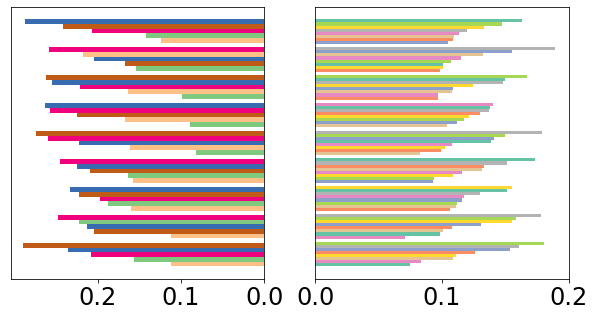

In [8]:

# Barplots

plot_grouped_barplot(ALL_CVS_PATH, NMFS_PATH, n_cvs=sig_cvs, nz_loadings=False)

## Heatmap

In [109]:
import matplotlib.colors as mpc

def darken(col):
    col = mpc.rgb_to_hsv(col)
    if col[1] < 0.909090909:
        col[1] = min(1.0, col[1] + 0.1)
    if col[2] < 0.909090909:
        col[2] = max(0.0, col[2] - 0.1)
        
    col = mpc.hsv_to_rgb(col)
    return col

def make_loadings_heatmap(cca_path, nmf_path, ax=None, fontsize=24, n_cvs=None, darken_lbls=False, 
                          norm=False, center=False, thresh=None, scale=False, nz_loadings=True, square=False,
                          show_numbers=False, **kwargs): 
    bm_bases_labels, oc_bases_labels = get_nmf_labels()
    bm_colors, oc_colors = get_nmf_colors()
    x_dweights, y_dweights = get_barplot_data(cca_path, nmf_path, n_cvs=n_cvs, thresh=thresh, nz_loadings=nz_loadings)
    
    X, Y = x_dweights.values, y_dweights.values
    
    if center:
        X = X - 1/X.shape[0]
        Y = Y - 1/Y.shape[0]
        if scale:
            Xstd = np.sqrt(np.square(X).sum(axis=0))
            Ystd = np.sqrt(np.square(Y).sum(axis=0))
            X = X/Xstd
            Y = Y/Ystd
        
    
    data = Y.T.dot(X)
    
    if square:
        data = np.square(data)
    
    if norm:
        data = (data - data.min()) / (data.max() - data.min())

    if ax is None:
        ax = plt.gca()
    kwargs.setdefault('cmap', 'Greys')
    
    col_order = np.argsort(np.abs(data).sum(axis=0))[::-1]
    row_order = np.argsort(np.abs(data).sum(axis=1))[::-1]
    
    data = data[row_order][:, col_order]
    print(data)
    
    col_labels = bm_bases_labels[col_order]
    row_labels = oc_bases_labels[row_order]
    
    col_labels = [l.replace('\n', ' ') for l in col_labels]
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    
    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="snow", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    bm_colors = [bm_colors[i] for i in col_order]
    oc_colors = [oc_colors[i] for i in row_order]

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=fontsize)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=fontsize)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    if show_numbers:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if abs(data[i, j]) < 0.001:
                    lbl = f'{data[i, j]:.1e}'.replace('e', '\ne')
                else:
                    lbl = f'{data[i, j]:.2g}'
                text = ax.text(j, i, lbl,
                               ha="center", va="center", color="w")
    
    for lbl, col in zip(ax.get_xticklabels(), bm_colors):
        if darken_lbls:
            col = darken(col)
        lbl.set_color(col)
        
        
    for lbl, col in zip(ax.get_yticklabels(), oc_colors):
        if darken_lbls:
            col = darken(col)
        lbl.set_color(col)
    
    return im

In [110]:
np.sqrt(np.square(np.arange(5)))

array([0., 1., 2., 3., 4.])

[[0.68117385 0.86324729 0.63724665 0.32831883 0.61355745]
 [0.63735246 0.37498993 0.47311066 0.11853244 0.06186912]
 [0.23515551 0.20632875 0.31254018 0.51439595 0.03701446]
 [0.27106603 0.27953752 0.38641145 0.01871454 0.27730389]
 [0.26753596 0.2935824  0.17565743 0.13036994 0.22543675]
 [0.07966074 0.03169648 0.02202732 0.27437934 0.03356444]
 [0.07075437 0.00847738 0.01438914 0.05393423 0.03312094]
 [0.00398164 0.00290582 0.00688569 0.00921764 0.02053504]]


/var/folders/78/w3lg7zbx0x1_nfk64y7_350r0000gn/T/ipykernel_98464/1258992621.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15, yticklabels={'fontsize': 24})


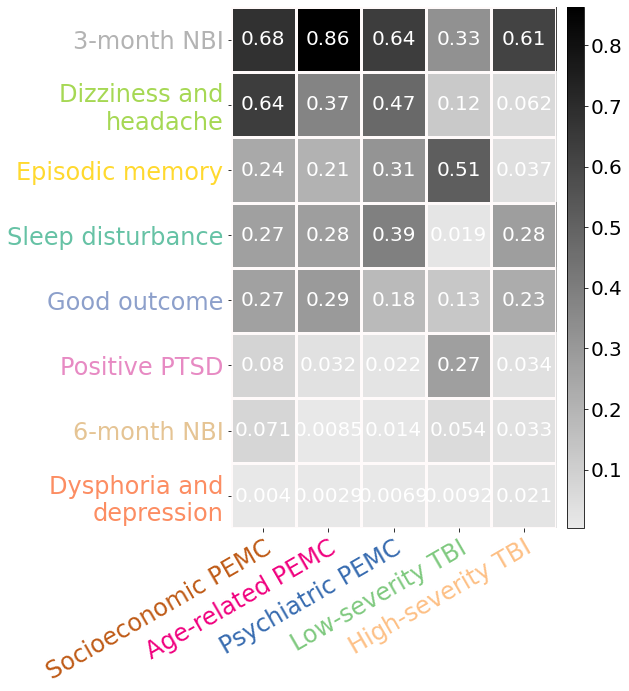

In [115]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

plt.figure(figsize=(10, 10))
ax = plt.gca()

ax.set_anchor((0,0))

s = mpc.LinearSegmentedColormap.from_list('mycmap', ['white', 'lightgray'])(0.5)
cmap = mpc.LinearSegmentedColormap.from_list('mycmap', [s, 'black'])



kwargs = dict(
    ax=ax, 
    n_cvs=sig_cvs, 
    fontsize=24, 
    show_numbers=True,
    nz_loadings=False,
    scale=True,
    center=True,
    square=True,
    cmap=cmap,
    #vmin=-1, vmax=1, cmap='RdGy'
)



im = make_loadings_heatmap(ALL_CVS_PATH, NMFS_PATH, **kwargs)
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15, yticklabels={'fontsize': 24})
#cax.tick_params('both', labelsize=24)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.savefig('../../paper/heatmap_cca_nmf_r2.png', dpi=100)

# Scatter

In [12]:
from activ.cca.viz import cross_decomp_scatter

def plot_scatters(path, axes=None, n_cvs=2, fontsize=24, **kwargs):

    if axes is None:
        fig, axes = plt.subplots(1, n_cvs, figsize=(5*n_cvs, 5))

    tbifile = TrackTBIFile(path)
    cv_bm = tbifile.cca.bm
    cv_oc = tbifile.cca.oc
    gcs_simple = tbifile.biomarkers[:, np.where(tbifile.biomarker_features == 'GCSMildModSevereRecode')[0][0]]
    
    gcs_hurd = np.zeros(len(gcs_simple), dtype='U8')
    gcs_hurd[gcs_simple == 0.0] = 'Mild'
    gcs_hurd[gcs_simple == 1.0] = 'Moderate'
    gcs_hurd[gcs_simple == 2.0] = 'Severe'
    
    for i in range(n_cvs):
        x = cv_bm[:, i]
        y = cv_oc[:, i]
        cross_decomp_scatter(x, y, fontsize=fontsize, labels=gcs_hurd, ax=axes[i], legend_fontsize=fontsize, **kwargs)

# MultiPanel Figure

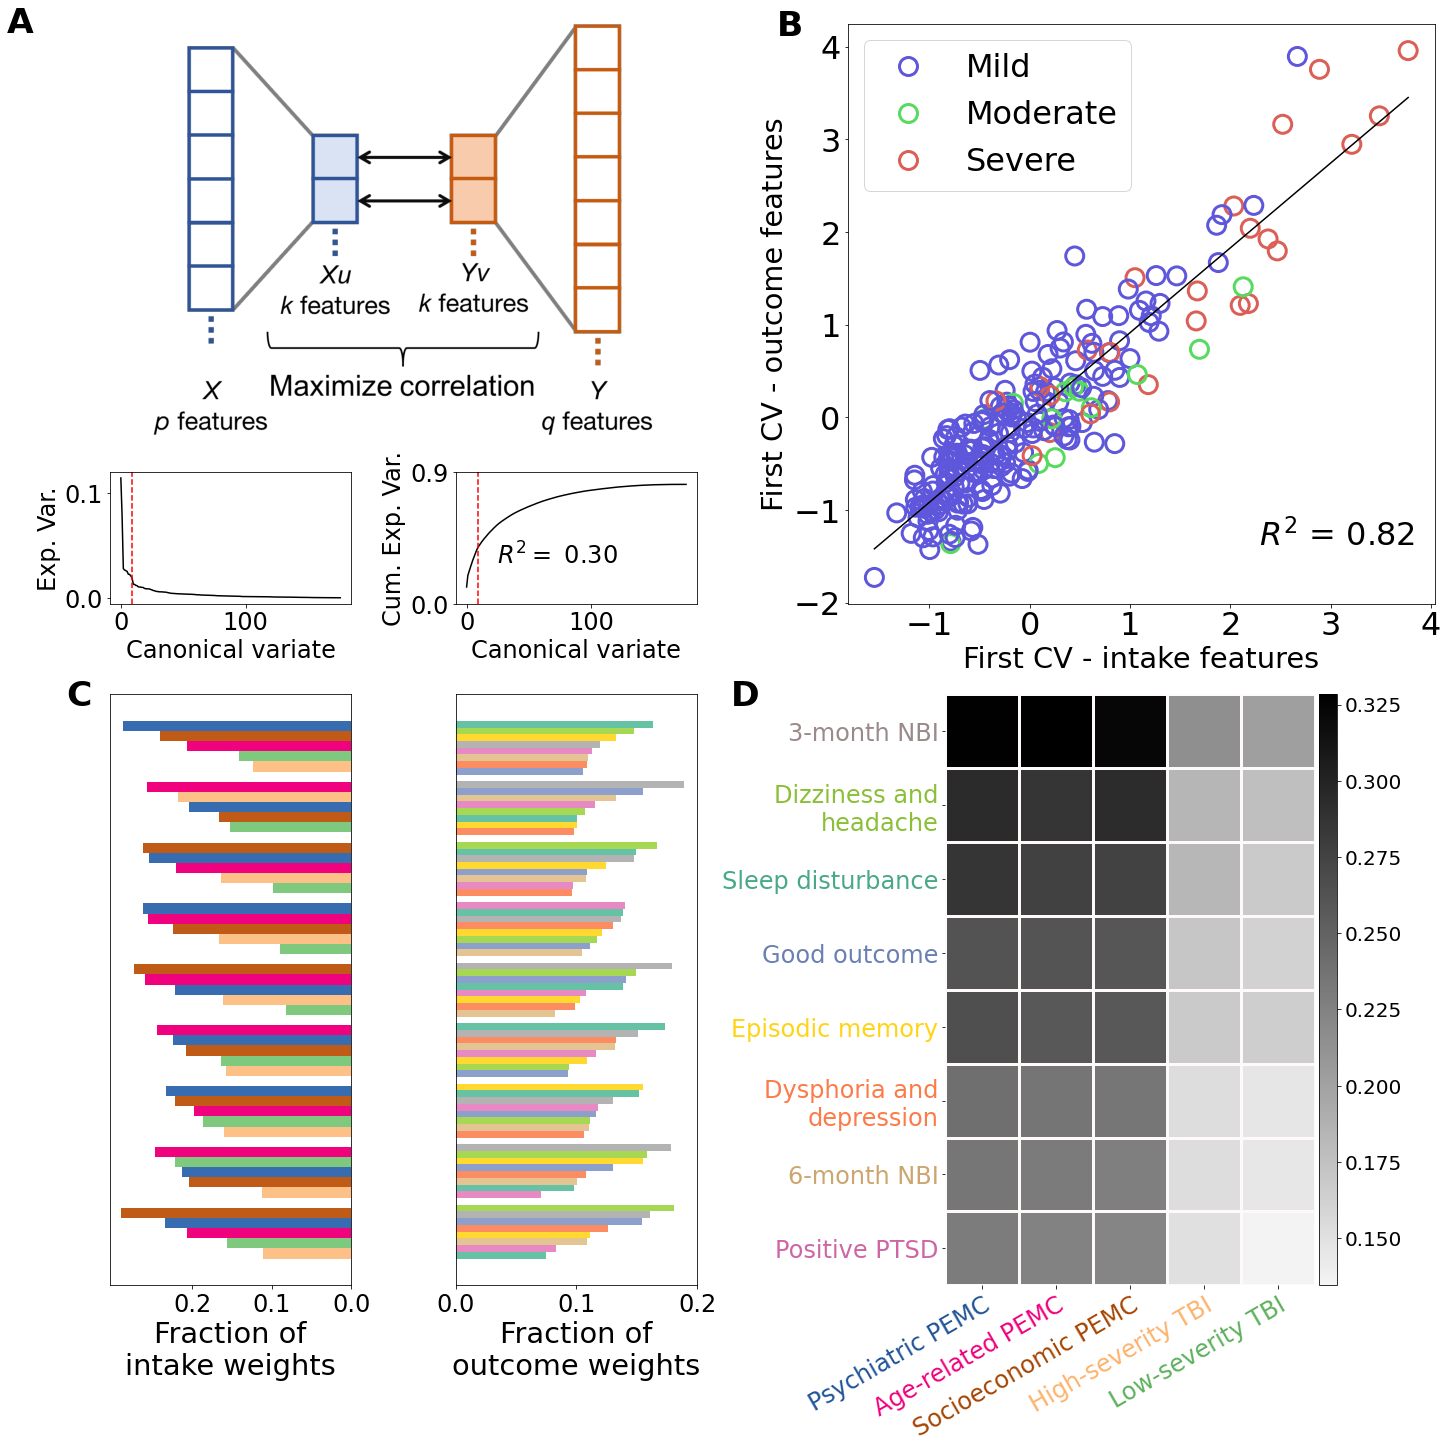

In [13]:
fig = plt.figure(figsize=(20, 20), constrained_layout=True)
mpl.rcParams['font.size'] = 20

q_x = 1
half_x = 2*q_x
x = 2 * half_x
gs = mgrid.GridSpec(nrows=2*x, ncols=2*x, figure=fig)

# Conceptual figure
ax_Concept = fig.add_subplot(gs[0:3*q_x, 0:x])
display_img(CONCEPTUAL_PATH, ax_Concept, border=0)


# Scatters
ax_Scatter = list()
ax_Scatter.append(fig.add_subplot(gs[:x, x:2*x]))
ax_Scatter[0].tick_params('both', labelsize='large')
plot_scatters(ALL_CVS_PATH, axes=ax_Scatter, markeredgewidth=3, markersize=18, n_cvs=1, fontsize=32)


size2 = 'x-large'
ax_Scatter[0].set_xlabel("First CV - intake features", fontsize=size2)
ax_Scatter[0].set_ylabel("First CV - outcome features", fontsize=size2)

# Predictive Heatmap
ax_LdHM = fig.add_subplot(gs[x:, x:2*x])
s = mpc.LinearSegmentedColormap.from_list('mycmap', ['white', 'lightgray'])(.25)
cmap = mpc.LinearSegmentedColormap.from_list('mycmap', [s, 'black'])
im = make_loadings_heatmap(ALL_CVS_PATH, NMFS_PATH, ax=ax_LdHM, n_cvs=sig_cvs, fontsize='large', darken_lbls=True, cmap=cmap, nz_loadings=False)
plt.colorbar(im, cax=make_axes_locatable(ax_LdHM).append_axes("right", size="5%", pad=0.05))




# Barplots
ax_BMBars = fig.add_subplot(gs[x:, 0:half_x])
ax_OCBars = fig.add_subplot(gs[x:, half_x:x])
ax_BMBars.set_xlabel("Fraction of\nintake weights", fontsize='x-large')
ax_OCBars.set_xlabel("Fraction of\noutcome weights", fontsize='x-large')
plot_grouped_barplot(ALL_CVS_PATH, NMFS_PATH, ax_bm=ax_BMBars, ax_oc=ax_OCBars, n_cvs=sig_cvs, nz_loadings=False)


def add_label(ax, label, x=-0.1, y=0.98 ):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size='xx-large')   
    
add_label(ax_Concept, "A", x=-0.25)
add_label(ax_Scatter[0], "B", x=-0.12)
add_label(ax_BMBars, "C", x=-0.18)
add_label(ax_LdHM, "D", x=-0.58)

# Cumulative Explained Variance
ax_ExpVar = fig.add_subplot(gs[3*q_x:x, 0:half_x])
ax_CumVar = fig.add_subplot(gs[3*q_x:x, half_x:x])
plot_exp_var(exp_var, ax=ax_ExpVar, n_cvs=N_CVS)
plot_cum_exp_var(exp_var, ax=ax_CumVar, n_cvs=N_CVS)

ax_Concept.xaxis.set_visible(False)
ax_ExpVar.title.set_visible(False)
ax_ExpVar.set_ylabel('Exp. Var.', fontsize=24)
ax_CumVar.set_ylabel('Cum. Exp. Var.', fontsize=24)

ypos = np.cumsum(exp_var[:N_CVS])[-1]
ax_CumVar.text(N_CVS+15, ypos * 0.9, "$R^2 = $ %0.2f" % ypos, fontsize=24)


plt.savefig('../../paper/MultiPanel_sparse_cca.fix.png', dpi=100)

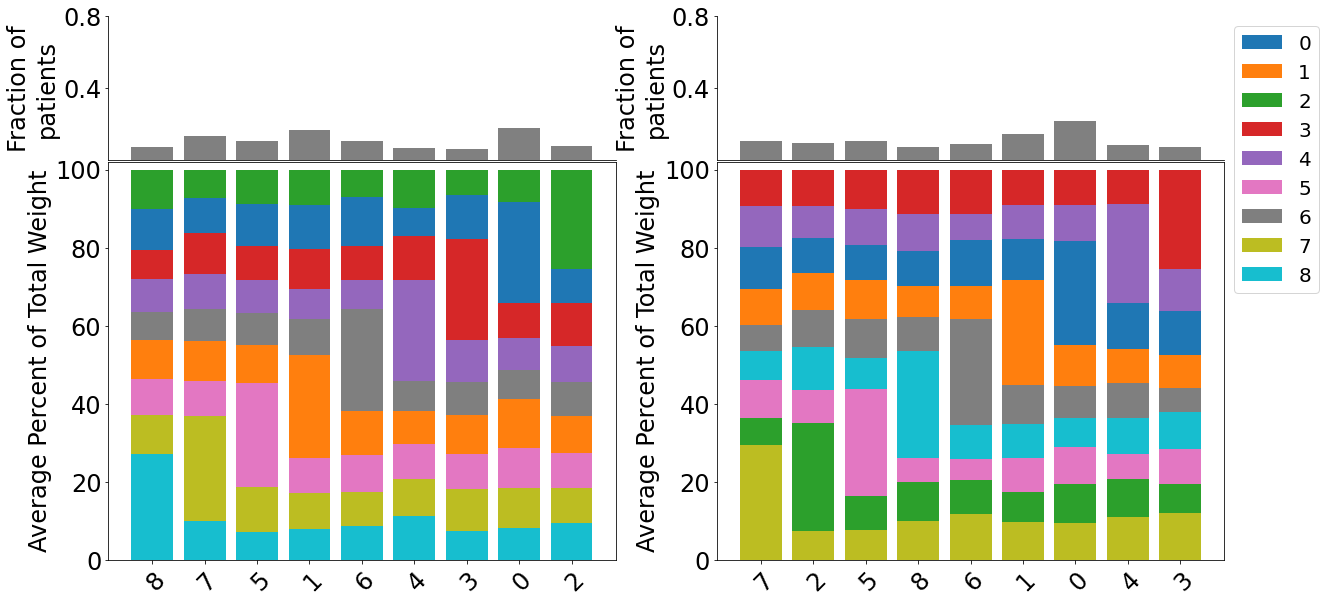

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from activ.nmf.viz import plot_weights
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

bm_weights = np.abs(tbifile.cca.bm[:, sig_cvs])
oc_weights = np.abs(tbifile.cca.oc[:, sig_cvs])

ax_BmWeights = axes[0]
ax_OcWeights = axes[1]
ax_BmBar = make_axes_locatable(ax_BmWeights).append_axes("top", 2.0, pad=0.02, sharex=ax_BmWeights)
ax_OcBar = make_axes_locatable(ax_OcWeights).append_axes("top", 2.0, pad=0.02, sharex=ax_OcWeights)
ax_BmWeights = [ax_BmBar, ax_BmWeights]
ax_OcWeights = [ax_OcBar, ax_OcWeights]


colors = [f'tab:{c}' for c in ('blue', 'orange', 'green', 'red', 'purple', 'pink', 'gray', 'olive', 'cyan')]

bm_order = plot_weights(bm_weights, colors, ax=ax_BmWeights, fontsize='large', labelsize='large')
oc_order = plot_weights(oc_weights, colors, ax=ax_OcWeights, fontsize='large', labelsize='large')

ax_OcBar.legend([mpatches.Patch(facecolor=c) for c in colors], 
                [str(x) for x in np.arange(len(colors))], 
                loc='best', bbox_to_anchor=(1.0, 1.0),
               bbox_transform=ax_OcBar.transAxes)
plt.savefig("../../paper/cca_weights_stacked_barplot.png", dpi=100)

In [15]:
from sklearn.decomposition import PCA

oc_pca = PCA().fit(tbifile.outcomes)

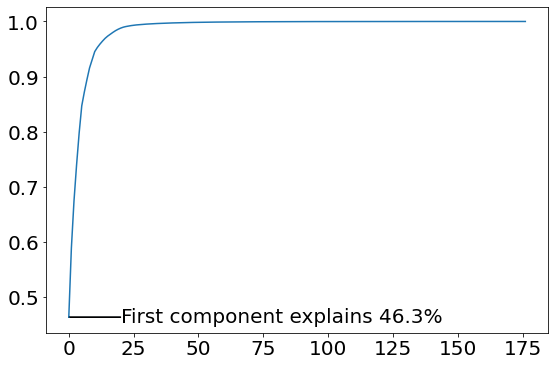

In [16]:
plt.figure(figsize=(9,6))
Y = np.cumsum(oc_pca.explained_variance_ratio_)
X = np.arange(len(Y))
plt.plot(X, Y)

xdx = X[0] + 20
plt.arrow(X[0] + 20, Y[0], -20, 0)
plt.text(xdx, Y[0]-.01, "First component explains %.1f%%" % (Y[0]*100))

plt.savefig('../../paper/outcome_pca.expvar.png')

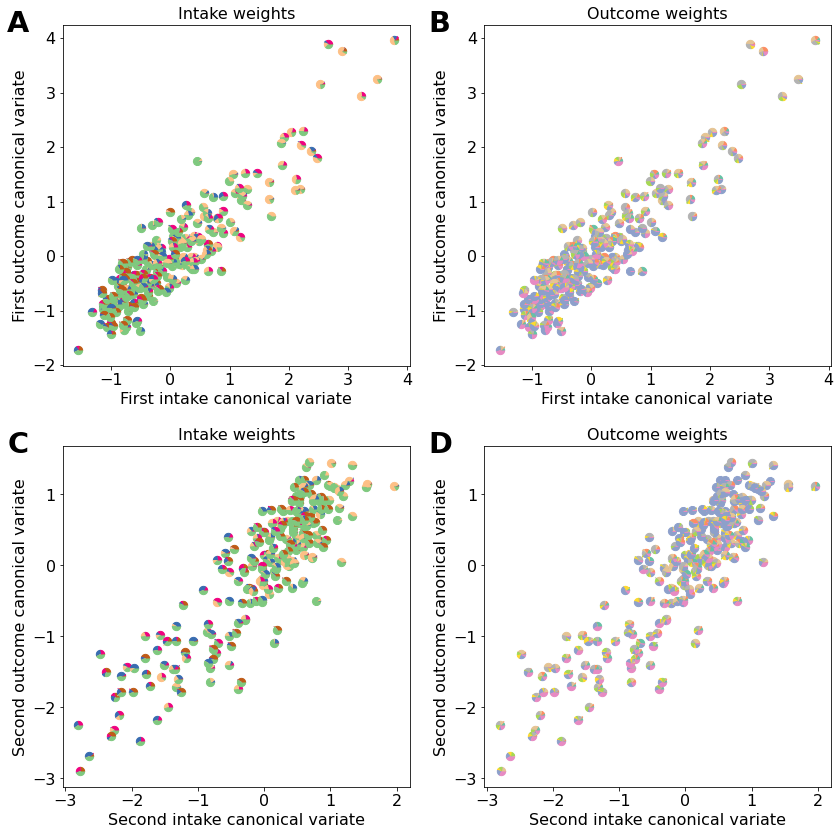

In [17]:
from activ.nmf.viz import plot_umap_nmf_piechart


nmf_tbifile = TrackTBIFile(NMFS_PATH)
bm_weights, bm_bases = nmf_tbifile.nmf.bm, nmf_tbifile.nmf.bm_bases
oc_weights, oc_bases = nmf_tbifile.nmf.oc, nmf_tbifile.nmf.oc_bases
bm_colors, oc_colors = get_nmf_colors()


tbifile = TrackTBIFile(ALL_CVS_PATH)
cv_bm = tbifile.cca.bm
cv_oc = tbifile.cca.oc

cv1 = np.array([cv_bm[:, 0], cv_oc[:, 0]]).T
cv2 = np.array([cv_bm[:, 1], cv_oc[:, 1]]).T

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

fs=16

plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), cv1, s=70, ax=axes[0, 0], fontsize=fs, palette=bm_colors)
axes[0, 0].set_title('Intake weights', fontsize=fs)
axes[0, 0].set_xlabel('First intake canonical variate')
axes[0, 0].set_ylabel('First outcome canonical variate')

plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), cv1, s=70, ax=axes[0, 1], fontsize=fs, palette=oc_colors)
axes[0, 1].set_title('Outcome weights', fontsize=fs)
axes[0, 1].set_xlabel('First intake canonical variate')
axes[0, 1].set_ylabel('First outcome canonical variate')


plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), cv2, s=70, ax=axes[1, 0], fontsize=fs, palette=bm_colors)
axes[1, 0].set_title('Intake weights', fontsize=fs)
axes[1, 0].set_xlabel('Second intake canonical variate')
axes[1, 0].set_ylabel('Second outcome canonical variate')

plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), cv2, s=70, ax=axes[1, 1], fontsize=fs, palette=oc_colors)
axes[1, 1].set_title('Outcome weights', fontsize=fs)
axes[1, 1].set_xlabel('Second intake canonical variate')
axes[1, 1].set_ylabel('Second outcome canonical variate')

def add_label(ax, label, x=-0.16, y=0.98 ):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size='x-large')  
    
for ax, lbl in zip(axes.ravel(), 'ABCD'):
    add_label(ax, lbl)

plt.tight_layout()
plt.savefig('../../paper/cca_nmf_piecharts.png', dpi=100)

USING make_loadings_heatmap_OLD
USING get_barplot_dfs_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
USING get_domain_weight_OLD
Index(['Age-related\nPEMC', 'High-severity\nTBI', 'Low-severity\nTBI',
       'Psychiatric\nPEMC', 'Socioeconomic\nPEMC'],
      dtype='object')
Index(['3-month NBI', '6-month NBI', 'Dizziness and\nheadache',
       'Dysphoria and\ndepression', 'Episodic memory', 'Good outcome',
       'Positive PTSD', 'Sleep disturbance'],
      dtype='object')


/var/folders/78/w3lg7zbx0x1_nfk64y7_350r0000gn/T/ipykernel_98464/1851305938.py:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15, yticklabels={'fontsize': 24})


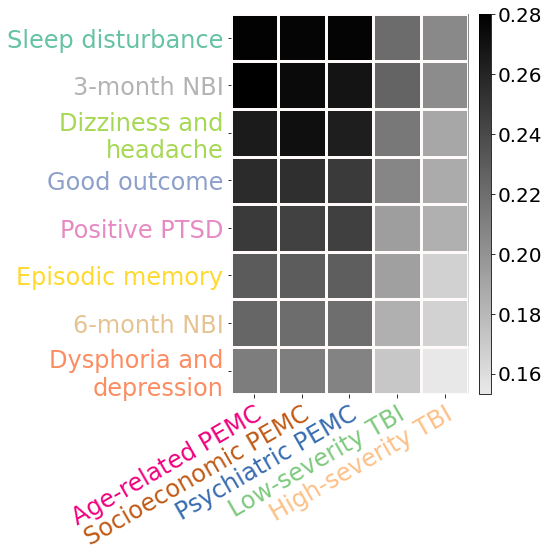

In [18]:
def get_domain_weight_OLD(df, ddict, coef, domain=True, subdomain=True, scale=False):
    """

    Args:
        scale: scale weights by the number of variables in the domain
    """
    print("USING get_domain_weight_OLD")
    weights = np.abs(coef[coef != 0])
#    weights = np.abs(coef)
    weights /= weights.sum()
    sub_data_dict = ddict.filter(items=df.columns[coef != 0], axis=0)
#    sub_data_dict = ddict.filter(items=df.columns, axis=0)
    dweight = dict()
    for d in np.unique(sub_data_dict):
        mask = (sub_data_dict == d).values.flatten()
        if scale:
            dweight[d] = weights[mask].mean()
        else:
            dweight[d] = weights[mask].sum()
    s = pd.Series(data = dweight)
    s /= s.sum()
    return s

def get_barplot_dfs_OLD(cca_path, nmf_path, n_cvs=None, thresh=None):
    print("USING get_barplot_dfs_OLD")
    tbifile = TrackTBIFile(cca_path)
    gcs_simple = tbifile.biomarkers[:, np.where(tbifile.biomarker_features == 'GCSMildModSevereRecode')[0][0]]
    
    bm_cv = tbifile.cca.bm
    oc_cv = tbifile.cca.oc
    
    bm_loadings = tbifile.cca.bm_bases
    oc_loadings = tbifile.cca.oc_bases

    index = np.arange(len(bm_loadings))
    if isinstance(n_cvs, int):
        bm_cv = bm_cv[:, :n_cvs]
        oc_cv = oc_cv[:, :n_cvs]
        bm_loadings = bm_loadings[:, :n_cvs]
        oc_loadings = oc_loadings[:, :n_cvs]
        index = np.arange(n_cvs)
    elif isinstance(n_cvs, (np.ndarray, list)):
        bm_cv = bm_cv[:, n_cvs]
        oc_cv = oc_cv[:, n_cvs]
        bm_loadings = bm_loadings[:, n_cvs]
        oc_loadings = oc_loadings[:, n_cvs]
        index = np.array(n_cvs)
        
    if thresh is not None:
        print('Removing small loadings')
        bm_loadings = drop_small(bm_loadings, thresh=thresh)
        oc_loadings = drop_small(oc_loadings, thresh=thresh)
        
    nmf_tbifile = TrackTBIFile(nmf_path)
    datadict_df = get_nmf_feature_types(nmf_tbifile)
    
    bm_df = nmf_tbifile.biomarker_df()
    oc_df = nmf_tbifile.outcome_df()

    x_dweights = list()
    y_dweights = list()
    scale = True
    for i in range(oc_loadings.shape[1]):
        x_dweight = get_domain_weight_OLD(bm_df, datadict_df, bm_loadings[:, i], scale=scale)
        y_dweight = get_domain_weight_OLD(oc_df, datadict_df, oc_loadings[:, i], scale=scale)
        x_dweight.name = '' #'CV-%d predictors' % (i+1)
        y_dweight.name = '' #'CV-%d outcomes' % (i+1)
        x_dweights.append(x_dweight.to_dict())
        y_dweights.append(y_dweight.to_dict())
    x_dweights = pd.DataFrame(data=x_dweights, index=index).fillna(0)
    y_dweights = pd.DataFrame(data=y_dweights, index=index).fillna(0)
    
    return x_dweights, y_dweights

def make_loadings_heatmap_OLD(cca_path, nmf_path, ax=None, fontsize=24, n_cvs=None, thresh=None, darken_lbls=False, **kwargs): 
    print("USING make_loadings_heatmap_OLD")
    bm_bases_labels, oc_bases_labels = get_nmf_labels()
    bm_colors, oc_colors = get_nmf_colors()
    x_dweights, y_dweights = get_barplot_dfs_OLD(cca_path, nmf_path, n_cvs=n_cvs, thresh=thresh)
    
    print(x_dweights.columns)
    print(y_dweights.columns)
    
    x_dweights = x_dweights[bm_bases_labels]
    y_dweights = y_dweights[oc_bases_labels]
    
    data = y_dweights.values.T.dot(x_dweights.values)

    if ax is None:
        ax = plt.gca()
    kwargs.setdefault('cmap', 'Greys')
    
    col_order = np.argsort(np.abs(data).sum(axis=0))[::-1]
    row_order = np.argsort(np.abs(data).sum(axis=1))[::-1]
    
    data = data[row_order][:, col_order]

    col_labels = bm_bases_labels[col_order]
    row_labels = oc_bases_labels[row_order]
    
    col_labels = [l.replace('\n', ' ') for l in col_labels]
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    
    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="snow", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    bm_colors = [bm_colors[i] for i in col_order]
    oc_colors = [oc_colors[i] for i in row_order]

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=fontsize)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=fontsize)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    
    for lbl, col in zip(ax.get_xticklabels(), bm_colors):
        if darken_lbls:
            col = darken(col)
        lbl.set_color(col)
        
        
    for lbl, col in zip(ax.get_yticklabels(), oc_colors):
        if darken_lbls:
            col = darken(col)
        lbl.set_color(col)
    
    return im


from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

plt.figure(figsize=(7, 7))
ax = plt.gca()

ax.set_anchor((0,0))

s = mpc.LinearSegmentedColormap.from_list('mycmap', ['white', 'lightgray'])(0.5)
cmap = mpc.LinearSegmentedColormap.from_list('mycmap', [s, 'black'])



im = make_loadings_heatmap_OLD(ALL_CVS_PATH, NMFS_PATH, ax=ax, n_cvs=sig_cvs, fontsize=24, cmap = cmap)
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15, yticklabels={'fontsize': 24})
#cax.tick_params('both', labelsize=24)
plt.colorbar(im, cax=cax)

In [19]:
df = pd.DataFrame(data={'A': [1,2,3], 'B': ['a', 'b', 'c'], 'C': [0.1, 0.2, 0.3]})
df

,A,B,C
0,1,a,0.1
1,2,b,0.2
2,3,c,0.3


In [20]:
df[['C', 'A', 'B']]

,C,A,B
0,0.1,1,a
1,0.2,2,b
2,0.3,3,c


In [21]:
def make_loadings_heatmap_OLD_OLD(cca_path, nmf_path, ax=None, fontsize=24, n_cvs=None, thresh=None, **kwargs): 
    bm_bases_labels, oc_bases_labels = get_nmf_labels()
    bm_colors, oc_colors = get_nmf_colors()
    x_dweights, y_dweights = get_barplot_dfs_OLD(cca_path, nmf_path, n_cvs=n_cvs, thresh=thresh)
    
    data = y_dweights.values.T.dot(x_dweights.values)

    if ax is None:
        ax = plt.gca()
    kwargs.setdefault('cmap', 'Greys')
    
    col_order = np.argsort(np.abs(data).sum(axis=0))[::-1]
    row_order = np.argsort(np.abs(data).sum(axis=1))[::-1]
    data = data[row_order][:, col_order]

    col_labels = bm_bases_labels[col_order]
    row_labels = oc_bases_labels[row_order]
    
    col_labels = [l.replace('\n', ' ') for l in col_labels]

    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=fontsize)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=fontsize)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im